In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.integrate import solve_ivp

print(torch.cuda.is_available())
print(torch.cuda.get_device_name() if torch.cuda.is_available() else "no gpu")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True
NVIDIA RTX 5000 Ada Generation


In [2]:
device

device(type='cuda')

# Load simple ODE


In [3]:
def hysteresis_ode(t,x,lam):
    return lam+x-x**3

def simulate_branch(lam_values, x0):
    x_vals = []
    x_curr = x0
    for lam in tqdm(lam_values):
        sol = solve_ivp(hysteresis_ode, [0, 50], [x_curr], args=(lam,), t_eval=[50])
        x_curr = sol.y[0, -1]  # final value
        x_vals.append(x_curr)
    return np.array(x_vals)

In [4]:
lam_start = -1 
lam_end = 1

lam_up = np.linspace(lam_start, lam_end, 250)
lam_down = np.linspace(lam_end, lam_start, 250)

In [5]:
x0=-1
x_increase = simulate_branch(lam_up, x0)
x_decrease = simulate_branch(lam_down,x_increase[-1])

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

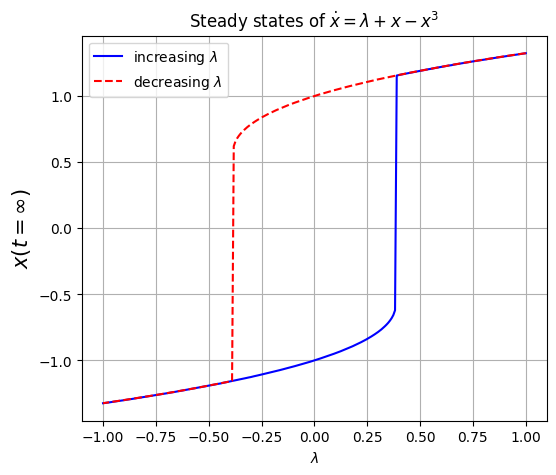

In [6]:

fig, ax = plt.subplots(1,1, figsize = (6,5))

ax.plot(lam_up, x_increase, c='blue', label=r'increasing $\lambda$')
ax.plot(lam_down, x_decrease, c='red', linestyle="--", label=r'decreasing $\lambda$')
ax.grid(True)
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel(r"$x(t = \infty)$",size = 15)
ax.set_title("Steady states of "+r"$\dot{x} = \lambda + x - x^3$")
ax.legend()
plt.show()

In [7]:
X = np.hstack((x_increase, x_decrease))
X = np.hstack((X,X))

lam_vals  = np.hstack((lam_up,lam_down))
lam_vals = np.hstack((lam_vals,lam_vals))

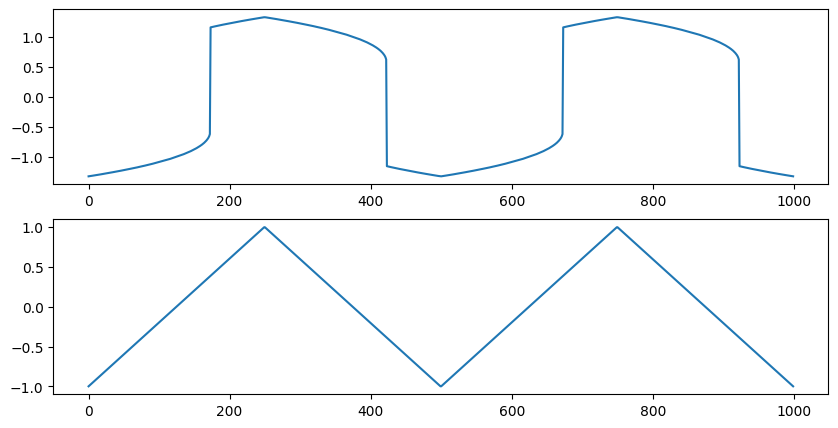

In [8]:
fig, ax = plt.subplots(2,1,figsize=(10,5))
ax[0].plot(X)
ax[1].plot(lam_vals)
plt.show()

# Neuro ODE approach

In [9]:
import numpy as np

import torch 
import torch.nn as nn
from torchdiffeq import odeint

In [10]:
def lam_func(t):
    lam_vals = np.hstack((lam_up,lam_down))
    idx = int(t) % len(lam_vals)
    return torch.tensor(lam_vals[idx], dtype=torch.float32, device=device)

In [11]:
class FTerm(nn.Module):
    def __init__(self,dim_in, dim_out, hidden_dim = 4):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_in, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, dim_out),
            nn.Tanh(),
        )
    def forward(self,x):
        return - torch.exp(self.network(x))


class GTerm(nn.Module):
    def __init__(self, dim_in, dim_out, hidden_dim = 4):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_in, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, dim_out),
            nn.Tanh(),
        )

    def forward(self, x, u):
        xu = torch.cat([x,u],dim=-1)
        return self.network(xu)


class ODEModel(nn.Module):
    def __init__(self,f,g):
        super().__init__()
        self.f = f
        self.g = g

    def forward(self, t, state, u_func):
        x = state
        u = u_func(t).unsqueeze(0).unsqueeze(1)
        fx = self.f(x)
        gx = self.g(x,u)
        return fx*(x-gx)

In [12]:

x_true = torch.tensor(X, dtype=torch.float32,device=device)
x0 = torch.tensor([[-1.0]], requires_grad=True, device=device)
dim_in = 1
dim_out = 1
f = FTerm(dim_in, dim_out).to(device)
g = GTerm(2, dim_out).to(device)

ode_model = ODEModel(f,g).to(device)


In [13]:
t_span = torch.arange(1000,dtype=torch.float32,device=device)

In [14]:
lam_func(t_span[0])

tensor(-1., device='cuda:0')

In [15]:
x_pred = odeint(lambda t, x: ode_model(t,x,lam_func),x0,t_span)

In [16]:
x_pred.squeeze().shape, X.squeeze().shape

(torch.Size([1000]), (1000,))

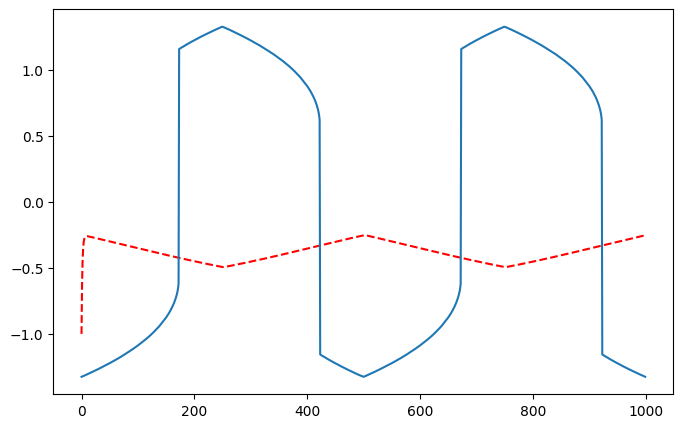

In [17]:
fig, ax = plt.subplots(1,1, figsize=(8,5))

ax.plot(x_pred.squeeze().detach().cpu().numpy(), linestyle='--',c='red')
ax.plot(x_true.squeeze().detach().cpu().numpy(),)
plt.show()


In [18]:

x_true.shape

torch.Size([1000])

In [19]:

loss_criteria = nn.MSELoss()
opt = torch.optim.Adam(list(f.parameters())+list(g.parameters()), lr=1e-3)

for epoch in tqdm(range(100)):
    opt.zero_grad()
    x_pred = odeint(lambda t, x: ode_model(t,x,lam_func), x0, t_span)
    loss = loss_criteria(x_pred.squeeze(), x_true.squeeze())
    loss.backward()
    opt.step()
    print(f"Epoch {epoch}: Loss = {loss.item():.4f}")
    

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0: Loss = 1.6099
Epoch 1: Loss = 1.6072
Epoch 2: Loss = 1.6046
Epoch 3: Loss = 1.6020
Epoch 4: Loss = 1.5994
Epoch 5: Loss = 1.5968
Epoch 6: Loss = 1.5943
Epoch 7: Loss = 1.5917
Epoch 8: Loss = 1.5891
Epoch 9: Loss = 1.5865
Epoch 10: Loss = 1.5840
Epoch 11: Loss = 1.5814
Epoch 12: Loss = 1.5789
Epoch 13: Loss = 1.5763
Epoch 14: Loss = 1.5738
Epoch 15: Loss = 1.5712
Epoch 16: Loss = 1.5687
Epoch 17: Loss = 1.5662
Epoch 18: Loss = 1.5637
Epoch 19: Loss = 1.5612
Epoch 20: Loss = 1.5587
Epoch 21: Loss = 1.5562
Epoch 22: Loss = 1.5537
Epoch 23: Loss = 1.5513
Epoch 24: Loss = 1.5488
Epoch 25: Loss = 1.5463
Epoch 26: Loss = 1.5439
Epoch 27: Loss = 1.5415
Epoch 28: Loss = 1.5390
Epoch 29: Loss = 1.5366
Epoch 30: Loss = 1.5342
Epoch 31: Loss = 1.5318
Epoch 32: Loss = 1.5293
Epoch 33: Loss = 1.5269
Epoch 34: Loss = 1.5246
Epoch 35: Loss = 1.5222
Epoch 36: Loss = 1.5198
Epoch 37: Loss = 1.5174
Epoch 38: Loss = 1.5151
Epoch 39: Loss = 1.5127
Epoch 40: Loss = 1.5103
Epoch 41: Loss = 1.5080
Ep

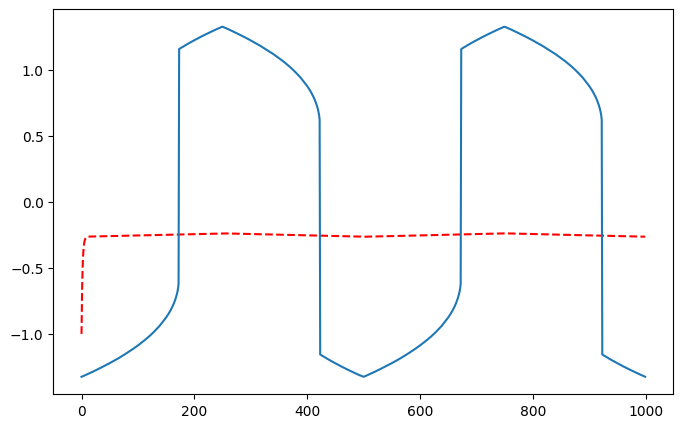

In [22]:
fig, ax = plt.subplots(1,1, figsize=(8,5))

x_pred = odeint(lambda t, x: ode_model(t,x,lam_func), x0, t_span)

ax.plot(x_pred.squeeze().detach().cpu().numpy(), linestyle='--',c='red')
ax.plot(x_true.squeeze().detach().cpu().numpy(),)
plt.show()

In [23]:
x_true[0]

tensor(-1.3246, device='cuda:0')